The pupose of the code is to test Hypothesis 4: **Bots engage less with content in terms of likes and retweets but may post content that is heavily retweeted within bot networks.**


Data Points: 'listed_count', 'statuses_count', 'favourites_count'.
Compare engagement metrics across suspected bots and human accounts. Bots might show a pattern of low engagement with others' content but high engagement within their network.


In [1]:
import numpy as np
import pandas as pd

In [4]:
url = 'https://raw.githubusercontent.com/amiism/DSA4263/main/data/UsersData/combined_users_full.csv'
df1 = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  11017 non-null  int64  
 1   name                                11016 non-null  object 
 2   screen_name                         11017 non-null  object 
 3   statuses_count                      11017 non-null  int64  
 4   followers_count                     11017 non-null  int64  
 5   friends_count                       11017 non-null  int64  
 6   favourites_count                    11017 non-null  int64  
 7   listed_count                        11017 non-null  int64  
 8   url                                 3508 non-null   object 
 9   lang                                10017 non-null  object 
 10  time_zone                           5015 non-null   object 
 11  location                            4908 

In [7]:
# Drop columns with zero non-null elements
df2 = df1.dropna(axis=1, how='all')

In [8]:
similar_split_columns=['url', 'default_profile_image', 'profile_background_tile', 'is_translator', 'protected', 'verified']

In [9]:
# Create df3 by dropping columns with more than 50% missing values and similar split between types
df3 = df2.drop(columns=similar_split_columns)

In [10]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  11017 non-null  int64  
 1   name                                11016 non-null  object 
 2   screen_name                         11017 non-null  object 
 3   statuses_count                      11017 non-null  int64  
 4   followers_count                     11017 non-null  int64  
 5   friends_count                       11017 non-null  int64  
 6   favourites_count                    11017 non-null  int64  
 7   listed_count                        11017 non-null  int64  
 8   lang                                10017 non-null  object 
 9   time_zone                           5015 non-null   object 
 10  location                            4908 non-null   object 
 11  default_profile                     1477 

In [12]:
# Filter suspected bots and human accounts
bots = df3[df3['Type'] == 'Bot']
humans = df3[df3['Type'] == 'Genuine']

# Calculate average engagement metrics for suspected bots and human accounts
avg_engagement_bots = bots[['listed_count', 'statuses_count', 'favourites_count']].mean()
avg_engagement_humans = humans[['listed_count', 'statuses_count', 'favourites_count']].mean()

# Print the average engagement metrics
print("Average engagement metrics for suspected bots:")
print(avg_engagement_bots)

print("\nAverage engagement metrics for human accounts:")
print(avg_engagement_humans)

Average engagement metrics for suspected bots:
listed_count          12.272571
statuses_count      1802.219144
favourites_count      29.011401
dtype: float64

Average engagement metrics for human accounts:
listed_count           19.496546
statuses_count      16958.220207
favourites_count     4669.620322
dtype: float64


There is a significant difference in average figures. But it could be because of outliers.

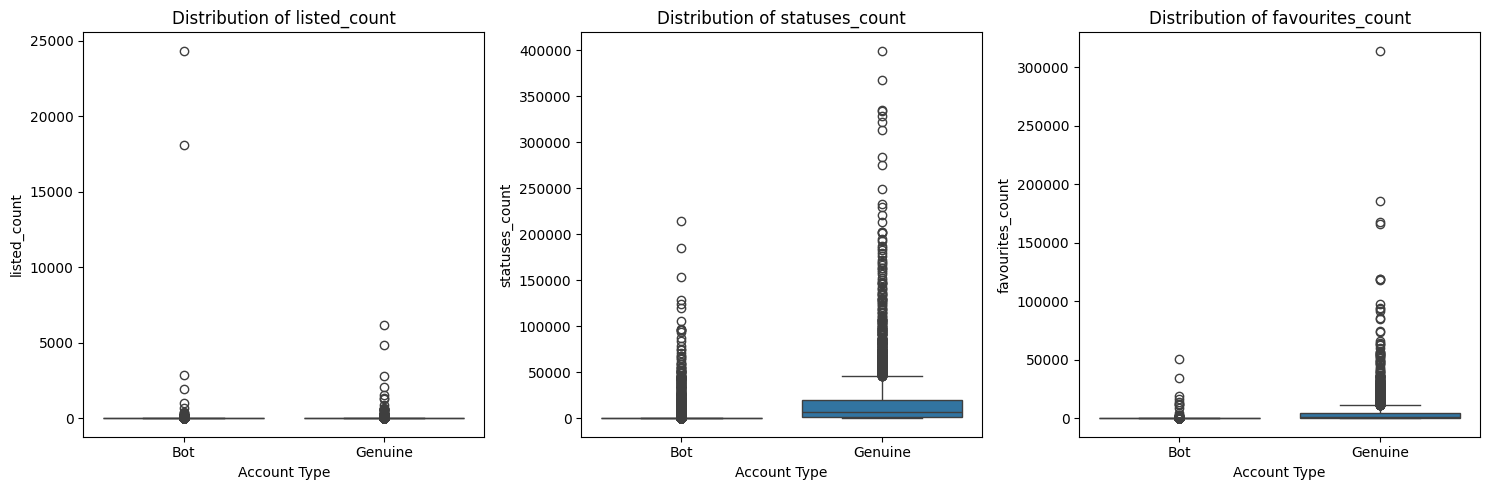

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the engagement metrics
engagement_metrics = ['listed_count', 'statuses_count', 'favourites_count']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(engagement_metrics), figsize=(15, 5))

# Plot boxplots for each engagement metric
for i, metric in enumerate(engagement_metrics):
    sns.boxplot(x='Type', y=metric, data=df3, ax=axes[i])
    axes[i].set_title(f'Distribution of {metric}')
    axes[i].set_xlabel('Account Type')
    axes[i].set_ylabel(metric)

plt.tight_layout()
plt.show()

The difference still seem significant and worth using in a model

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

#Using a simple Log reg model to test if this hypothesis could be a good predictor

engagement_metrics = ['listed_count', 'statuses_count', 'favourites_count']

# Split data into features (X) and target (y)
X = df3[engagement_metrics]
y = df3['Type']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train logistic regression model
model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
model.fit(X_train, y_train)

# Predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.896551724137931

Classification Report:
              precision    recall  f1-score   support

         Bot       0.88      0.99      0.93      1528
     Genuine       0.96      0.69      0.80       676

    accuracy                           0.90      2204
   macro avg       0.92      0.84      0.87      2204
weighted avg       0.90      0.90      0.89      2204



Confusion Matrix:
[[1509   19]
 [ 209  467]]


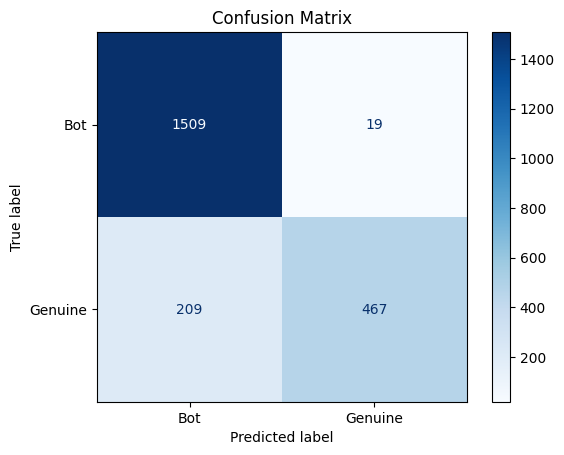

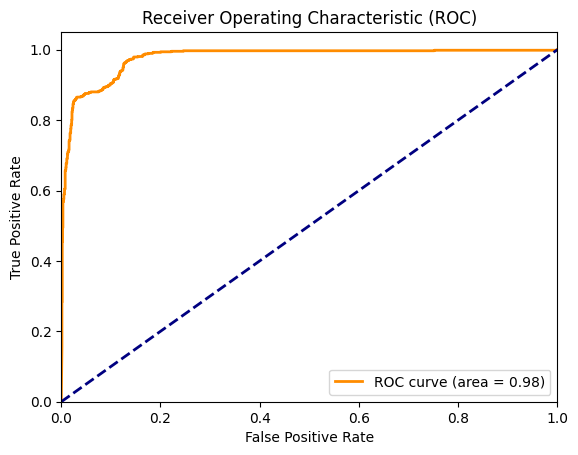

In [25]:
#import sklearn.metrics
#!pip install confusion_matrix, plot_confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Bot', 'Genuine'], cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds, pos_label='Genuine')
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()